In [1]:
# We start by importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.base import clone
import warnings
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning

# Defining Runge-function

In [2]:
#Reproducible setup
np.random.seed(73)
rng = np.random.default_rng(73)

def runge_function(x, noise=True):
    y = 1 / (1 + 25 * x**2)
    if noise:
        y += np.random.normal(0, 0.1, size=x.shape)
    return y


In [3]:
# Defining polynomial feature expansion
def polynomial_features(x, degree, intercept=True):
    n = len(x)
    if intercept:
        X = np.zeros((n, degree+1))
        X[:, 0] = 1
        for i in range(1, degree+1):
            X[:, i] = x**i
    else:
        X = np.zeros((n, degree))
        for i in range(degree):
            X[:, i] = x**(i+1)
    return X

In [4]:
#Defining OLS fitting function
def ols_fit(X, y):
    return np.linalg.pinv(X) @ y



In [5]:
# Reproducible setup
datapoints = [10, 50, 100, 200, 500, 1000]
poly_degrees = list(range(1, 16))
results_ols = {}

# Running OLS for various n and polynomial degrees
for n in datapoints:
    x = np.linspace(-1, 1, n)
    y = runge_function(x, 0.5)

    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)

    for p in poly_degrees:
        Xp = polynomial_features(x, p, intercept=False)
        X_train, X_test = Xp[idx_train, :], Xp[idx_test, :]
        y_train, y_test = y[idx_train], y[idx_test]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        y_offset = y_train.mean()
        y_train_s, y_test_s = y_train - y_offset, y_test - y_offset

        theta = ols_fit(X_train_s, y_train_s)

        y_hat_train, y_hat_test = X_train_s @ theta, X_test_s @ theta

        mse_train = np.mean((y_train_s - y_hat_train)**2)
        mse_test = np.mean((y_test_s - y_hat_test)**2)

        R2_train = 1 - np.sum((y_train_s - y_hat_train)**2) / np.sum((y_train_s - y_train_s.mean())**2)
        R2_test = 1 - np.sum((y_test_s - y_hat_test)**2) / np.sum((y_test_s - y_train_s.mean())**2)

        results_ols[(n, p)] = {
            "theta": theta,
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train, "R2_test": R2_test,
        }


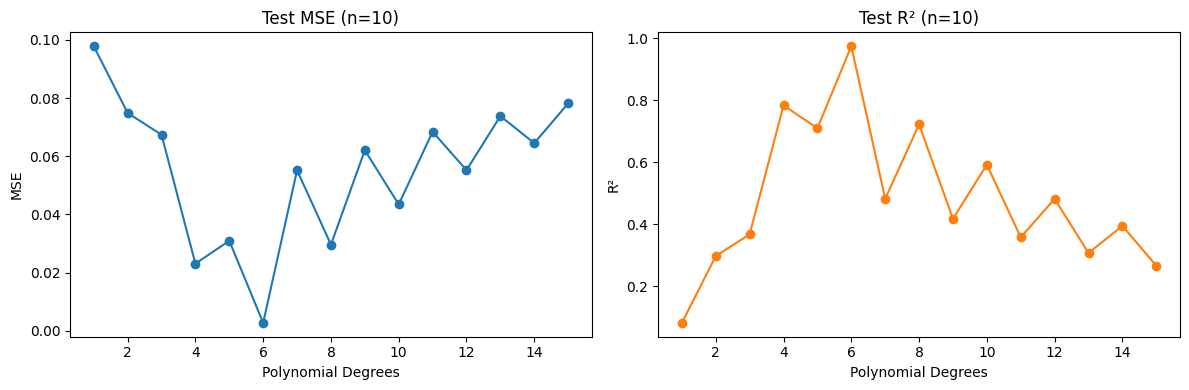

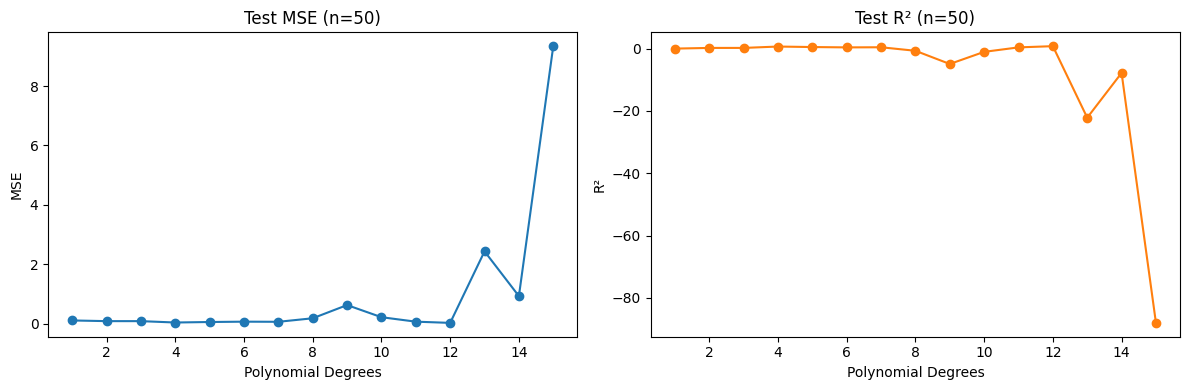

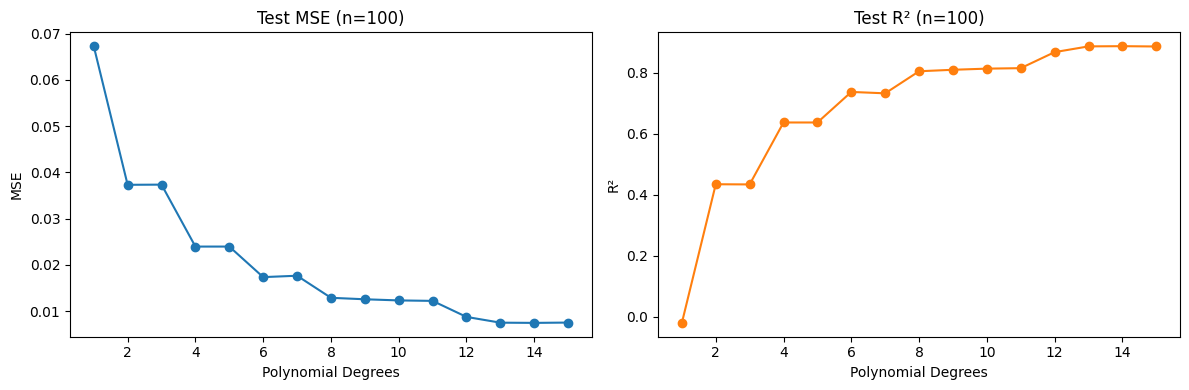

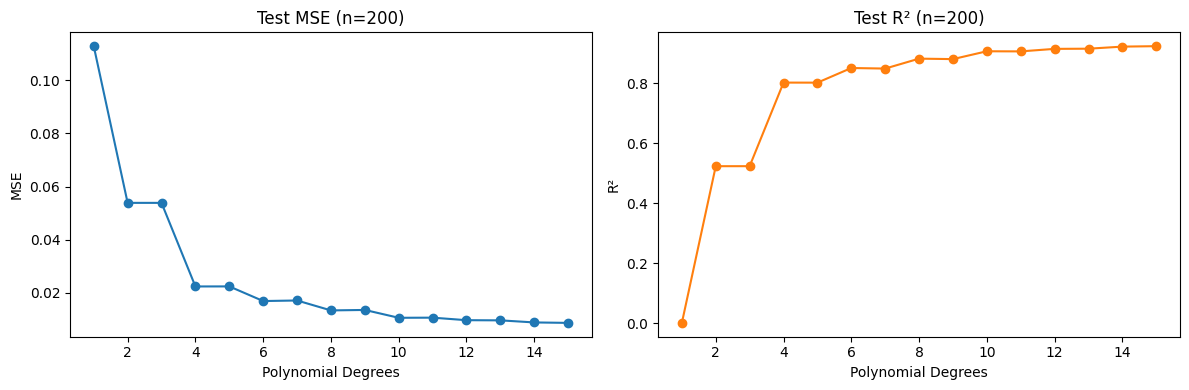

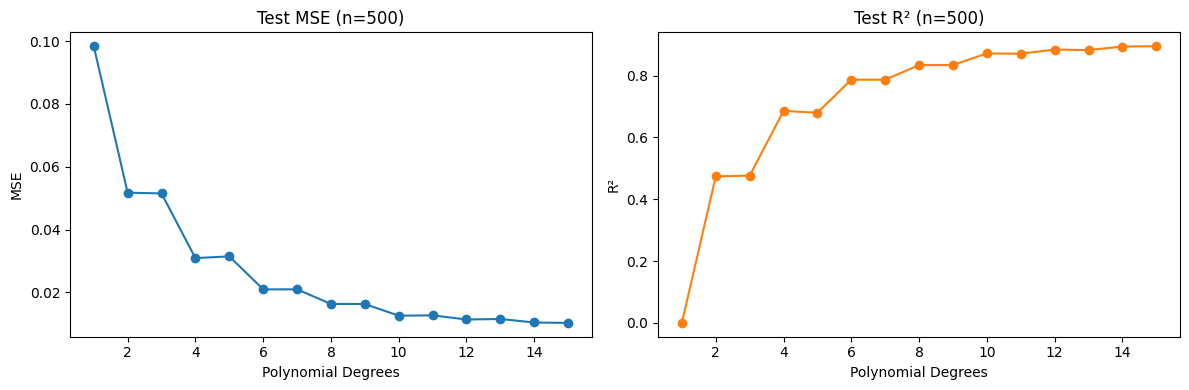

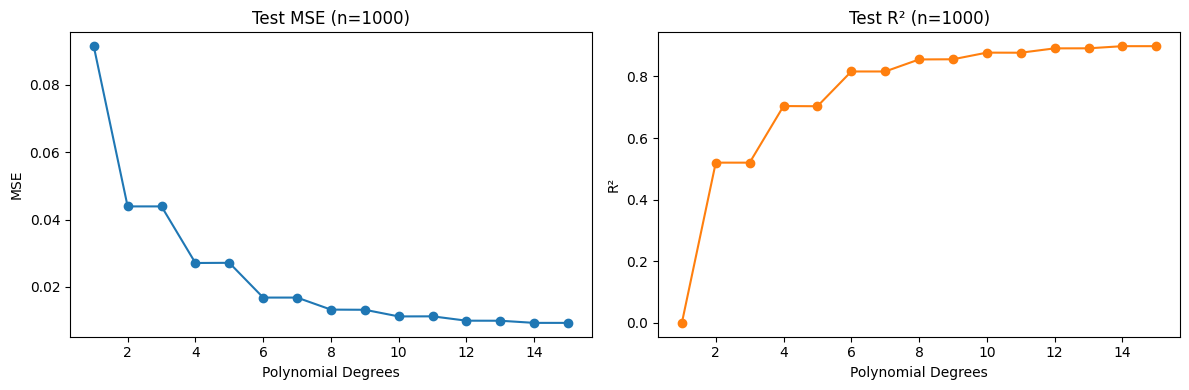

In [6]:
# Plotting test MSE and R² for fixed n as polynomial degree varies
def plot_mse_r2(results, n_values):
    for n_focus in n_values:
        ps = sorted({p for (n_key, p) in results.keys() if n_key == n_focus})
        mse_values = [results[(n_focus, p)]["mse_test"] for p in ps]
        r2_values = [results[(n_focus, p)]["R2_test"] for p in ps]

        fig, axes = plt.subplots(1, 2, figsize=(12,4))

        # MSE plot
        axes[0].plot(ps, mse_values, marker="o", color="tab:blue")
        axes[0].set_title(f"Test MSE (n={n_focus})")
        axes[0].set_xlabel("Polynomial Degrees")
        axes[0].set_ylabel("MSE")

        # R² plot
        axes[1].plot(ps, r2_values, marker="o", color="tab:orange")
        axes[1].set_title(f"Test R² (n={n_focus})")
        axes[1].set_xlabel("Polynomial Degrees")
        axes[1].set_ylabel("R²")

        plt.tight_layout()
        plt.show()

plot_mse_r2(results_ols, datapoints)



In [7]:
#Plotting train MSE and R²
def plot_train_mse_r2(results):
    ns = sorted({n for (n, _) in results.keys()})
    ps = sorted({p for (_, p) in results.keys()})

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for n_focus in ns:
        values = [results[(n_focus, p)]["mse_train"] for p in ps]
        axes[0].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[0].set_title("Train MSE - OLS")
    axes[0].set_xlabel("Polynomial Degrees")
    axes[0].set_ylabel("MSE")
    axes[0].legend(title="Datapoints")

    for n_focus in ns:
        values = [results[(n_focus, p)]["R2_train"] for p in ps]
        axes[1].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[1].set_title("Train R² - OLS")
    axes[1].set_xlabel("Polynomial Degrees")
    axes[1].set_ylabel("R²")
    axes[1].legend(title="Datapoints")

    plt.tight_layout()
    plt.show()


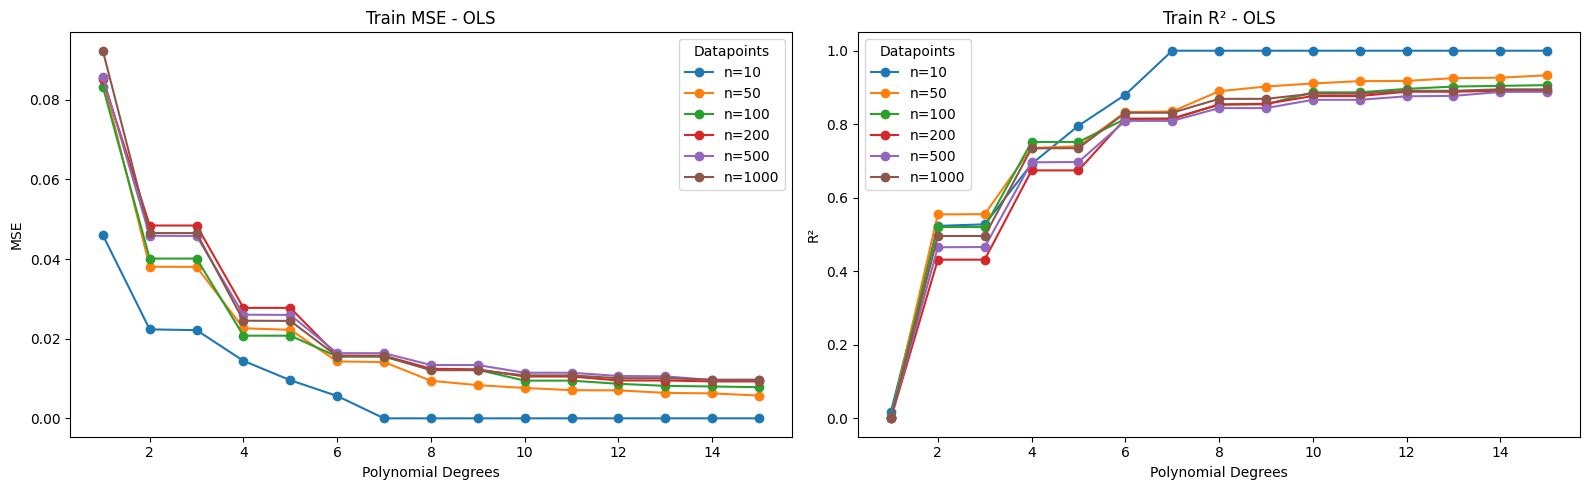

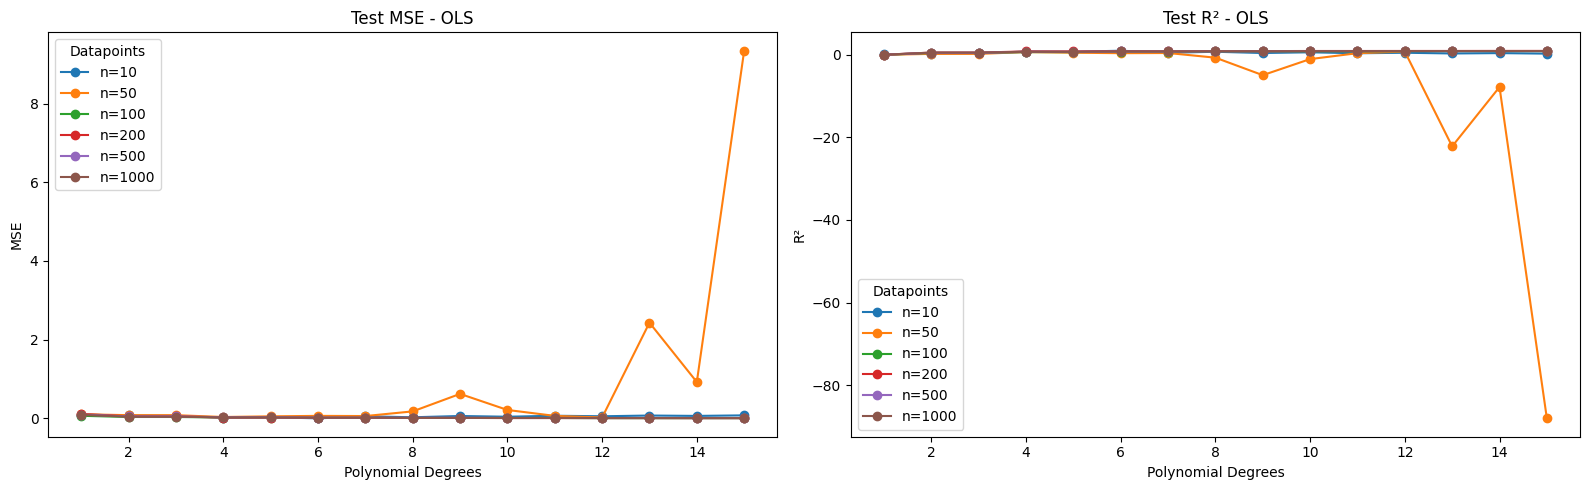

In [8]:
#Plotting test MSE and R²
def plot_test_mse_r2(results):
    ns = sorted({n for (n, _) in results.keys()})
    ps = sorted({p for (_, p) in results.keys()})

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for n_focus in ns:
        values = [results[(n_focus, p)]["mse_test"] for p in ps]
        axes[0].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[0].set_title("Test MSE - OLS")
    axes[0].set_xlabel("Polynomial Degrees")
    axes[0].set_ylabel("MSE")
    axes[0].legend(title="Datapoints")

    for n_focus in ns:
        values = [results[(n_focus, p)]["R2_test"] for p in ps]
        axes[1].plot(ps, values, marker="o", label=f"n={n_focus}")
    axes[1].set_title("Test R² - OLS")
    axes[1].set_xlabel("Polynomial Degrees")
    axes[1].set_ylabel("R²")
    axes[1].legend(title="Datapoints")

    plt.tight_layout()
    plt.show()

plot_train_mse_r2(results_ols)
plot_test_mse_r2(results_ols)



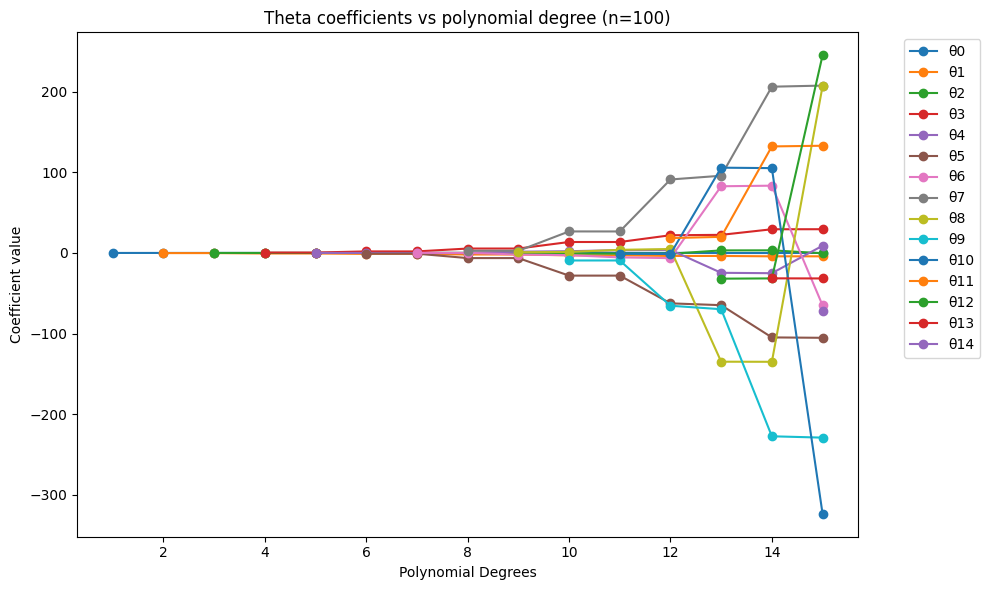

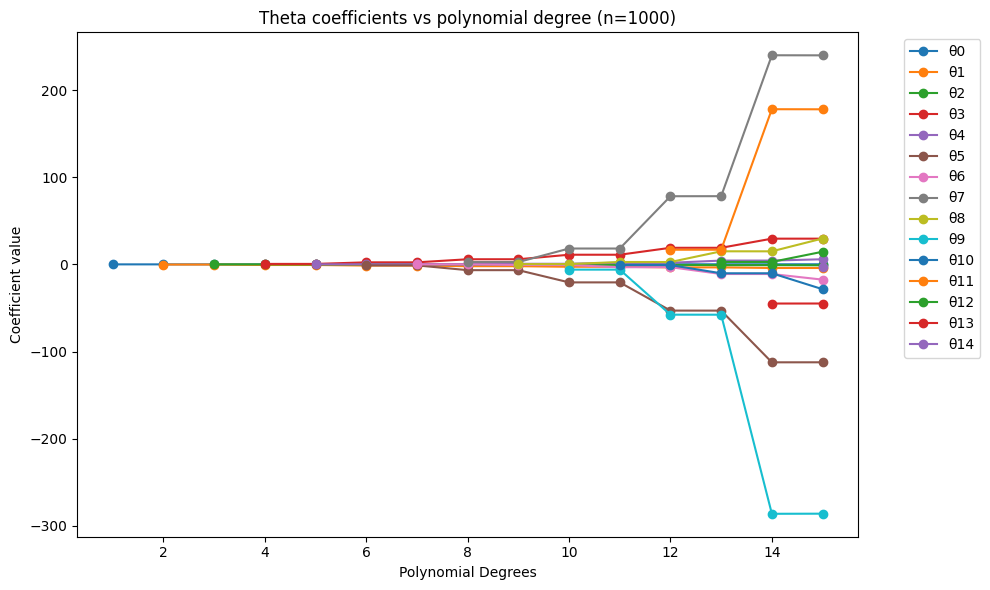

In [9]:
# Plotting theta coefficients for a fixed n as polynomial degree varies
def plot_theta(results, n_focus):
    ps = sorted({p for (n_key, p) in results.keys() if n_key == n_focus})
    thetas = [results[(n_focus, p)]["theta"] for p in ps if (n_focus, p) in results]

    if not thetas:
        print(f"No results found for n={n_focus}")
        return

    plt.figure(figsize=(10,6))

    max_len = max(len(theta) for theta in thetas)
    for j in range(max_len):
        coeffs = [theta[j] if j < len(theta) else np.nan for theta in thetas]
        plt.plot(ps, coeffs, marker="o", label=f"θ{j}")

    plt.title(f"Theta coefficients vs polynomial degree (n={n_focus})")
    plt.xlabel("Polynomial Degrees")
    plt.ylabel("Coefficient value")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


# Plot theta
plot_theta(results_ols, n_focus=100)
plot_theta(results_ols, n_focus=1000)


In [10]:
def summarize_results(results, n_values, degrees, metric):
    data = []
    for n in n_values:
        for p in degrees:
            if (n, p) in results:
                data.append({
                    "n": n,
                    "degree": p,
                    metric: results[(n, p)][metric]
                })
    return pd.DataFrame(data)

# summary
df_mse_test = summarize_results(results_ols, datapoints, poly_degrees, "mse_test")
df_r2_test  = summarize_results(results_ols, datapoints, poly_degrees, "R2_test")

display(df_mse_test.head(10))
display(df_r2_test.head(10))


,n,degree,mse_test
0,10,1,0.097842
1,10,2,0.074882
2,10,3,0.067382
3,10,4,0.023043
4,10,5,0.030908
5,10,6,0.002678
6,10,7,0.055170
7,10,8,0.029592
8,10,9,0.062043
9,10,10,0.043429


,n,degree,R2_test
0,10,1,0.082425
1,10,2,0.297748
2,10,3,0.368086
3,10,4,0.783901
4,10,5,0.710142
5,10,6,0.974888
6,10,7,0.482613
7,10,8,0.722481
8,10,9,0.418151
9,10,10,0.592719


In [11]:
# Finding best polynomial degree per dataset size based on lowest test MSE
best_models = df_mse_test.loc[df_mse_test.groupby("n")["mse_test"].idxmin()]
print("Best polynomial degree per dataset size (based on lowest test MSE):")
display(best_models)


Best polynomial degree per dataset size (based on lowest test MSE):


,n,degree,mse_test
5,10,6,0.002678
26,50,12,0.024119
43,100,14,0.007463
59,200,15,0.008703
74,500,15,0.010332
89,1000,15,0.009306


# Task b - Ridge Regression

In [12]:
# Defining Ridge regression fitting function
def ridge_fit(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    return np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y

lambdas = [1e-6, 1e-4, 1e-2, 0.1, 1, 10]
results_ridge = {}

# Running Ridge regression
for n in datapoints:
    x = np.linspace(-1, 1, n)
    y = runge_function(x, 0.5)

    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)

    for p in poly_degrees:
        Xp = polynomial_features(x, p, intercept=False)
        X_train, X_test = Xp[idx_train, :], Xp[idx_test, :]
        y_train, y_test = y[idx_train], y[idx_test]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        y_offset = y_train.mean()
        y_train_s, y_test_s = y_train - y_offset, y_test - y_offset

        for lam in lambdas:
            theta = ridge_fit(X_train_s, y_train_s, lam)
            y_hat_train, y_hat_test = X_train_s @ theta, X_test_s @ theta

            mse_train = np.mean((y_train_s - y_hat_train)**2)
            mse_test = np.mean((y_test_s - y_hat_test)**2)

            R2_train = 1 - np.sum((y_train_s - y_hat_train)**2) / np.sum((y_train_s - y_train_s.mean())**2)
            R2_test = 1 - np.sum((y_test_s - y_hat_test)**2) / np.sum((y_test_s - y_train_s.mean())**2)

            results_ridge[(n, p, lam)] = {
                "theta": theta,
                "mse_train": mse_train, "mse_test": mse_test,
                "R2_train": R2_train, "R2_test": R2_test
            }

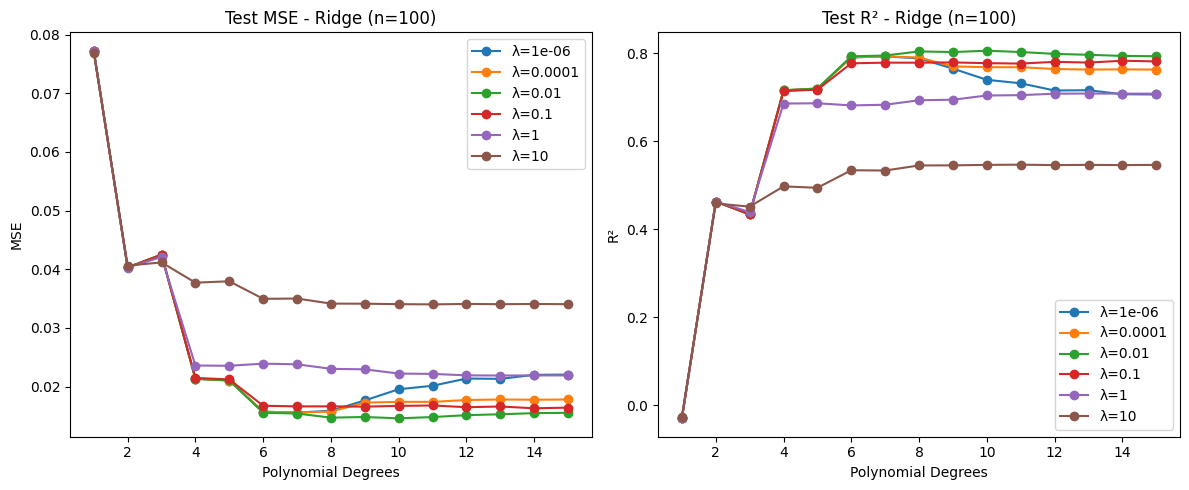

In [13]:
# Plotting Ridge results (test MSE and R²)
def plot_ridge_mse_r2(results, n_focus, lam_values):
    ps = sorted({p for (n, p, lam) in results.keys() if n == n_focus})

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    for lam in lam_values:
        values = [results[(n_focus, p, lam)]["mse_test"] for p in ps]
        axes[0].plot(ps, values, marker="o", label=f"λ={lam}")
    axes[0].set_title(f"Test MSE - Ridge (n={n_focus})")
    axes[0].set_xlabel("Polynomial Degrees")
    axes[0].set_ylabel("MSE")
    axes[0].legend()

    for lam in lam_values:
        values = [results[(n_focus, p, lam)]["R2_test"] for p in ps]
        axes[1].plot(ps, values, marker="o", label=f"λ={lam}")
    axes[1].set_title(f"Test R² - Ridge (n={n_focus})")
    axes[1].set_xlabel("Polynomial Degrees")
    axes[1].set_ylabel("R²")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_ridge_mse_r2(results_ridge, n_focus=100, lam_values=lambdas)


In [14]:
# Summarizing Ridge results
def summarize_ridge(results, datapoints, degrees, lambdas):
    data = []
    for n in datapoints:
        for p in degrees:
            for lam in lambdas:
                if (n, p, lam) in results:
                    entry = results[(n, p, lam)]
                    data.append({
                        "n": n,
                        "degree": p,
                        "lambda": lam,
                        "MSE_test": entry["mse_test"],
                        "R2_test": entry["R2_test"]
                    })
    return pd.DataFrame(data)

df_ridge = summarize_ridge(results_ridge, datapoints, poly_degrees, lambdas)
best_ridge = df_ridge.loc[df_ridge.groupby("n")["MSE_test"].idxmin()]

display(best_ridge)


,n,degree,lambda,MSE_test,R2_test
26,10,5,0.010000,0.000019,0.999779
138,50,9,0.000001,0.028003,0.829759
236,100,10,0.010000,0.014596,0.805448
324,200,10,0.000001,0.012236,0.838496
444,500,15,0.000001,0.008834,0.914165
528,1000,14,0.000001,0.010564,0.888178


# Part C

In [15]:
# Defining gradient descent for OLS and Ridge
def gradient_descent(X, y, lr=0.01, n_iter=1000, lam=0.0):
    """
    Gradient Descent for OLS (lam=0) eller Ridge (lam>0).
    Returner:
        theta: learned coefficients
        costs: MSE at each iteration
    """
    n, m = X.shape
    theta = np.random.randn(m)
    costs = []

    for _ in range(n_iter):
        y_pred = X @ theta
        gradient = (2/n) * X.T @ (y_pred - y) + 2 * lam * theta
        theta -= lr * gradient

        cost = np.mean((y - y_pred)**2)
        costs.append(cost)

    return theta, costs


In [16]:
n = 100
p = 10
x = np.linspace(-1, 1, n)
y = runge_function(x, 0.5)

Xp = polynomial_features(x, p, intercept=False)
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=73)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

y_offset = y_train.mean()
y_train_s = y_train - y_offset
y_test_s  = y_test - y_offset

# Gradient descent training
theta_gd, costs = gradient_descent(X_train_s, y_train_s, lr=0.01, n_iter=2000, lam=0.0)

# Predictions and metrics
y_pred_test = X_test_s @ theta_gd
mse_test = np.mean((y_test_s - y_pred_test)**2)
r2_test  = 1 - np.sum((y_test_s - y_pred_test)**2) / np.sum((y_test_s - y_train_s.mean())**2)

print(f"GD OLS → Test MSE: {mse_test:.5f}, R²: {r2_test:.3f}")


GD OLS → Test MSE: 0.03795, R²: 0.494


In [17]:
theta_ols = np.linalg.pinv(X_train_s.T @ X_train_s) @ X_train_s.T @ y_train_s
y_pred_ols = X_test_s @ theta_ols

mse_ols = np.mean((y_test_s - y_pred_ols)**2)
r2_ols  = 1 - np.sum((y_test_s - y_pred_ols)**2) / np.sum((y_test_s - y_train_s.mean())**2)

print(f"Analytical OLS → Test MSE: {mse_ols:.5f}, R²: {r2_ols:.3f}")


Analytical OLS → Test MSE: 0.00985, R²: 0.869


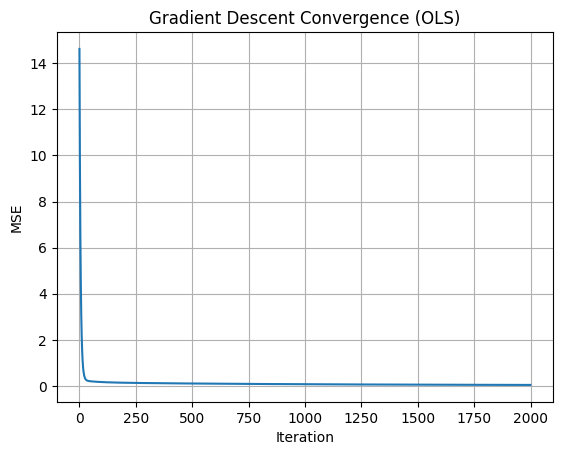

In [18]:
plt.plot(costs)
plt.title("Gradient Descent Convergence (OLS)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


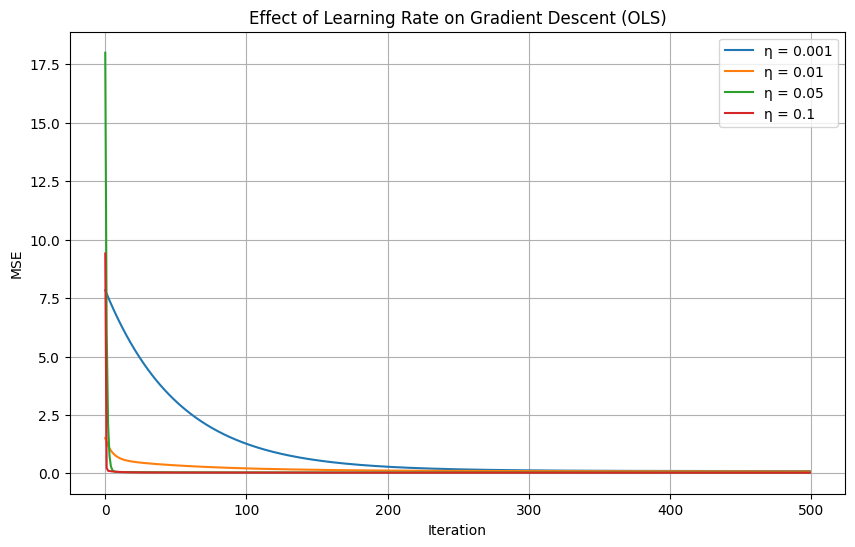

In [19]:
learning_rates = [0.001, 0.01, 0.05, 0.1]

plt.figure(figsize=(10, 6))
for eta in learning_rates:
    _, cost_curve = gradient_descent(X_train_s, y_train_s, lr=eta, n_iter=500)
    plt.plot(cost_curve, label=f"η = {eta}")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Effect of Learning Rate on Gradient Descent (OLS)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import pandas as pd

# Learning rates to test
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
n_iter = 20000
lam = 0.0  # OLS

summary = []

# Running GD for each learning rate
for lr in learning_rates:
    theta_gd, costs = gradient_descent(X_train_s, y_train_s, lr=lr, n_iter=n_iter, lam=lam)
    y_pred = X_test_s @ theta_gd
    mse = mean_squared_error(y_test_s, y_pred)
    r2  = r2_score(y_test_s, y_pred)
    summary.append({
        "Method": f"GD (η={lr})",
        "MSE (test)": round(mse, 5),
        "R² (test)": round(r2, 4),
        "Final cost": round(costs[-1], 5)
    })

#Add analytical solution
theta_ana = ols_fit(X_train_s, y_train_s)
y_pred_ana = X_test_s @ theta_ana
mse_ana = mean_squared_error(y_test_s, y_pred_ana)
r2_ana  = r2_score(y_test_s, y_pred_ana)

summary.insert(0, {
    "Method": "Analytical OLS",
    "MSE (test)": round(mse_ana, 5),
    "R² (test)": round(r2_ana, 4),
    "Final cost": "-"
})

# Create and display the summary
df_summary = pd.DataFrame(summary)
display(df_summary)


,Method,MSE (test),R² (test),Final cost
0,Analytical OLS,0.00985,0.8474,-
1,GD (η=0.001),0.03042,0.5289,0.03225
2,GD (η=0.005),0.01809,0.7198,0.02039
3,GD (η=0.01),0.02373,0.6325,0.02414
4,GD (η=0.05),0.01809,0.7199,0.0201
5,GD (η=0.1),0.01199,0.8143,0.01631


# Part D

In [21]:
# Defining advanced GD methods
def gradient_descent_advanced(X, y, lr=0.01, n_iter=1000, lam=0.0,
                              method='momentum', beta1=0.9, beta2=0.999, eps=1e-8):
    n, m = X.shape
    theta = np.random.randn(m)
    costs = []

    v = np.zeros(m)
    r = np.zeros(m)
    m_t = np.zeros(m)

    for t in range(1, n_iter + 1):
        y_pred = X @ theta
        grad = (2/n) * X.T @ (y_pred - y) + 2 * lam * theta

        if method == 'momentum':
            v = beta1 * v + (1 - beta1) * grad
            theta -= lr * v

        elif method == 'adagrad':
            r += grad**2
            theta -= (lr / (np.sqrt(r) + eps)) * grad

        elif method == 'rmsprop':
            r = beta1 * r + (1 - beta1) * grad**2
            theta -= (lr / (np.sqrt(r) + eps)) * grad

        elif method == 'adam':
            m_t = beta1 * m_t + (1 - beta1) * grad
            r = beta2 * r + (1 - beta2) * grad**2
            m_hat = m_t / (1 - beta1**t)
            r_hat = r / (1 - beta2**t)
            theta -= lr * m_hat / (np.sqrt(r_hat) + eps)

        cost = np.mean((y - y_pred)**2)
        costs.append(cost)

    return theta, costs


In [22]:
n = 100
p = 10
x = np.linspace(-1, 1, n)
y = runge_function(x, 0.5)

Xp = polynomial_features(x, p, intercept=False)
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=73)

methods = ['momentum', 'adagrad', 'rmsprop', 'adam']
results = {}

for method in methods:
    theta, costs = gradient_descent_advanced(X_train, y_train, lr=0.01, n_iter=1000,
                                             lam=0.0, method=method)
    y_pred = X_test @ theta
    mse = np.mean((y_test - y_pred)**2)
    r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
    results[method] = {'MSE': mse, 'R2': r2, 'costs': costs}


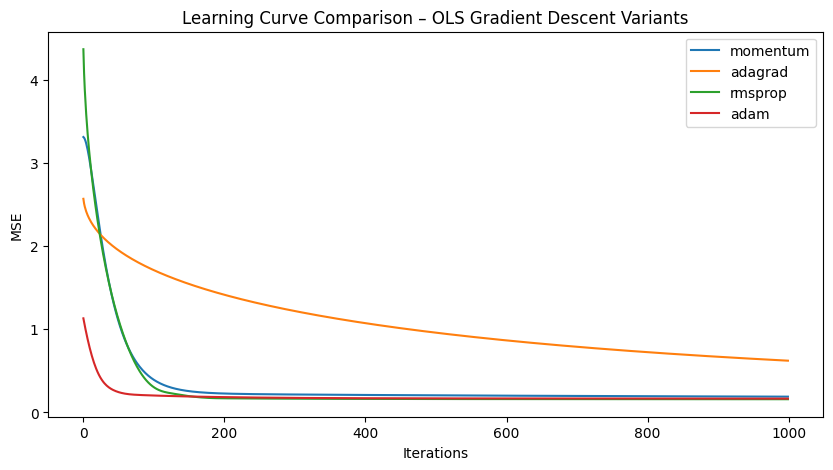

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for method, res in results.items():
    plt.plot(res["costs"], label=method)
plt.title("Learning Curve Comparison – OLS Gradient Descent Variants")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [24]:
# Creating a df of the results
df_results = pd.DataFrame({
    method.capitalize(): {
        "MSE": res["MSE"],
        "R²": res["R2"]
    }
    for method, res in results.items()
}).T

df_results = df_results.round(5)

# display the table
print("\nPerformance comparison of learning rate update methods (Test set):")
display(df_results)



Performance comparison of learning rate update methods (Test set):


,MSE,R²
Momentum,0.13517,-0.95854
Adagrad,0.59825,-7.66828
Rmsprop,0.10096,-0.46281
Adam,0.10279,-0.48933


# Part E

In [25]:
# Data and features
def runge_function(x: np.ndarray, noise_std: float = 0.05) -> np.ndarray:
    """
    Runge function with optional noise.
    """
    return 1 / (1 + 25 * x**2) + np.random.normal(0, noise_std, size=len(x))


def polynomial_features(x: np.ndarray, degree: int, intercept: bool = False) -> np.ndarray:
    X = np.column_stack([x**i for i in range(1, degree + 1)])
    if intercept:
        X = np.c_[np.ones(len(x)), X]
    return X


def add_intercept(X: np.ndarray) -> np.ndarray:
    return np.c_[np.ones(X.shape[0]), X]

In [26]:
#  Metrics
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred) ** 2))


def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    return 1.0 - ss_res / ss_tot


def baseline_mse(y_true: np.ndarray) -> float:
    """MSE from predicting the mean of y_true."""
    return mse(y_true, np.full_like(y_true, np.mean(y_true), dtype=float))


In [27]:
# Smooth part (OLS)
def grad_mse(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Gradient of (1/n)*||y - Xθ||^2. This is the "nice" part for ISTA/FISTA.
    """
    n = X.shape[0]
    return (2.0 / n) * (X.T @ (X @ theta - y))


def lasso_objective(X: np.ndarray, y: np.ndarray, theta: np.ndarray, lam: float) -> float:
    """
    (1/n)*||y - Xθ||^2 + λ * ||θ_{1:}||_1
    Note: θ_0 (intercept) is not penalized.
    """
    n = X.shape[0]
    resid = y - X @ theta
    return float(resid @ resid) / n + lam * float(np.sum(np.abs(theta[1:])))

In [28]:
def soft_threshold(z: np.ndarray, tau: float) -> np.ndarray:
    """
    Soft-thresholding: pulls small values to exactly zero, shrinking the large ones.
    """
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)


def lipschitz_constant(X: np.ndarray) -> float:
    """
    L = (2/n)*sigma_max(X)^2 for f(θ) = (1/n)||y - Xθ||^2.
    We use it to pick a safe step size η = 1/(L * safety).
    """
    n = X.shape[0]
    smax = np.linalg.svd(X, compute_uv=False)[0]
    return (2.0 / n) * (smax**2)

In [29]:
# ISTA
def lasso_ista(
    X: np.ndarray,
    y: np.ndarray,
    lam: float = 1e-3,
    lr: float | None = None,
    iters: int = 3000,
    theta0: np.ndarray | None = None,
    safety: float = 1.05,
):
    """
    Plain proximal gradient for LASSO. One gradient step on MSE, then a soft-threshold on θ[1:].
    """
    p = X.shape[1]
    theta = np.zeros(p) if theta0 is None else theta0.copy()

    if lr is None:
        L = lipschitz_constant(X)
        lr = 1.0 / (L * safety)

    costs = []
    for _ in range(iters):
        z = theta - lr * grad_mse(X, y, theta)
        theta = np.concatenate(([z[0]], soft_threshold(z[1:], lr * lam)))
        costs.append(lasso_objective(X, y, theta, lam))

    return theta, costs, lr


In [30]:
#FISTA
def lasso_fista(
    X: np.ndarray,
    y: np.ndarray,
    lam: float = 1e-3,
    lr: float | None = None,
    iters: int = 3000,
    theta0: np.ndarray | None = None,
    safety: float = 1.05,
):
    """
    FISTA: same idea as ISTA, but with Nesterov acceleration. Usually converges faster.
    """
    p = X.shape[1]
    theta = np.zeros(p) if theta0 is None else theta0.copy()

    if lr is None:
        L = lipschitz_constant(X)
        lr = 1.0 / (L * safety)

    yk = theta.copy()
    tk = 1.0
    costs = []

    for _ in range(iters):
        z = yk - lr * grad_mse(X, y, yk)
        theta_next = np.concatenate(([z[0]], soft_threshold(z[1:], lr * lam)))
        t_next = 0.5 * (1 + np.sqrt(1 + 4 * tk * tk))
        yk = theta_next + ((tk - 1) / t_next) * (theta_next - theta)
        theta, tk = theta_next, t_next
        costs.append(lasso_objective(X, y, theta, lam))

    return theta, costs, lr

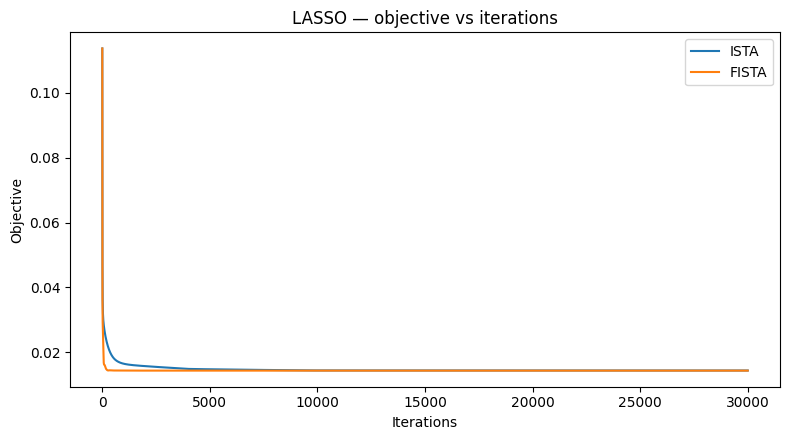


LASSO results (same λ for all; α=λ/2 for sklearn):


,MSE (test),R^2 (test),Step size (η),Nonzeros (θ≠0),Baseline MSE
ISTA,0.008695,0.856371,0.091901,6,0.060537
FISTA,0.007879,0.869847,0.091901,6,0.060537
sklearn-Lasso,0.007879,0.869843,NaN,6,0.060537


In [31]:
# Reproducible setup
np.random.seed(42)

# Data
n, degree = 100, 10
x = np.linspace(-1, 1, n)
y = runge_function(x, noise_std=0.05)

#Features and split
X = polynomial_features(x, degree, intercept=False)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=73)

# Standardize using train reults add intercept after scaling
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s  = scaler.transform(X_te)
X_tr_b  = add_intercept(X_tr_s)   # θ_0 will not be penalized
X_te_b  = add_intercept(X_te_s)

# One lambda for all
lam = 1e-3
iters = 30000

# ISTA
th_i, costs_i, lr_i = lasso_ista(X_tr_b, y_tr, lam=lam, iters=iters)
yhat_i = X_te_b @ th_i
mse_i  = mse(y_te, yhat_i)
r2_i   = r2_score(y_te, yhat_i)
nnz_i  = int(np.count_nonzero(th_i[1:]))

# FISTA
th_f, costs_f, lr_f = lasso_fista(X_tr_b, y_tr, lam=lam, iters=iters)
yhat_f = X_te_b @ th_f
mse_f  = mse(y_te, yhat_f)
r2_f   = r2_score(y_te, yhat_f)
nnz_f  = int(np.count_nonzero(th_f[1:]))

# scikit-learn (same scaling no extra intercept)
#sklearn objective: (1/(2n))||y - Xw||^2 + α||w||_1.  match with α = λ/2
alpha = lam / 2.0
sk = Lasso(alpha=alpha, fit_intercept=False, max_iter=200000, tol=1e-6)
sk.fit(X_tr_b, y_tr)
yhat_sk = sk.predict(X_te_b)
mse_sk  = mse(y_te, yhat_sk)
r2_sk   = r2_score(y_te, yhat_sk)
nnz_sk  = int(np.count_nonzero(sk.coef_[1:])) if sk.coef_.shape[0] == X_tr_b.shape[1] else int(np.count_nonzero(sk.coef_))

#Learning curves
plt.figure(figsize=(8, 4.5))
plt.plot(costs_i, label="ISTA")
plt.plot(costs_f, label="FISTA")
plt.title("LASSO — objective vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.legend()
plt.tight_layout()
plt.show()

# Results table and rounding
df = pd.DataFrame({
    "MSE (test)":     {"ISTA": mse_i, "FISTA": mse_f, "sklearn-Lasso": mse_sk},
    "R^2 (test)":     {"ISTA": r2_i, "FISTA": r2_f, "sklearn-Lasso": r2_sk},
    "Step size (η)":  {"ISTA": lr_i, "FISTA": lr_f, "sklearn-Lasso": np.nan},
    "Nonzeros (θ≠0)": {"ISTA": nnz_i, "FISTA": nnz_f, "sklearn-Lasso": nnz_sk},
    "Baseline MSE":   {"ISTA": baseline_mse(y_te), "FISTA": baseline_mse(y_te), "sklearn-Lasso": baseline_mse(y_te)},
}).round(6)

print("\nLASSO results (same λ for all; α=λ/2 for sklearn):")
try:
    display(df)
except NameError:
    print(df)



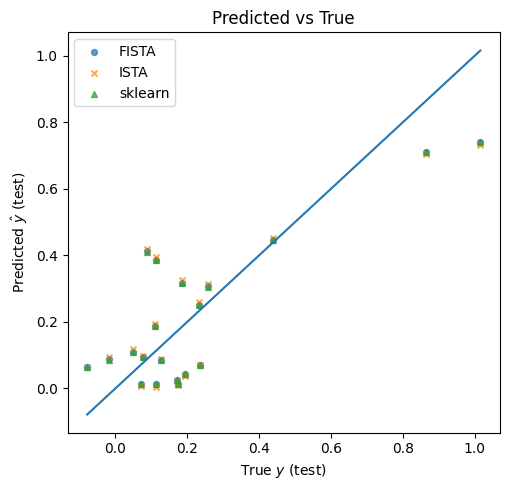

In [32]:
plt.figure(figsize=(5.2,5))
plt.scatter(y_test, yhat_f, s=18, alpha=0.7, label="FISTA")
plt.scatter(y_test, yhat_i, s=18, alpha=0.7, label="ISTA", marker="x")
plt.scatter(y_test, yhat_sk, s=18, alpha=0.7, label="sklearn", marker="^")
yl = [min(y_test.min(), yhat_f.min(), yhat_i.min(), yhat_sk.min()),
      max(y_test.max(), yhat_f.max(), yhat_i.max(), yhat_sk.max())]
plt.plot(yl, yl)  # 45-degree
plt.xlabel("True $y$ (test)")
plt.ylabel("Predicted $\\hat y$ (test)")
plt.title("Predicted vs True")
plt.legend()
plt.tight_layout()
plt.show()


# Task F

In [33]:
# Data, features and the metrics
def runge_function(x: np.ndarray, noise_std: float = 0.05) -> np.ndarray:
    return 1/(1 + 25*x**2) + np.random.normal(0, noise_std, size=len(x))

def polynomial_features(x: np.ndarray, degree: int) -> np.ndarray:
    return np.column_stack([x**i for i in range(1, degree+1)])

def add_intercept(X: np.ndarray) -> np.ndarray:
    return np.c_[np.ones(X.shape[0]), X]

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    d = y_true - y_pred
    return float(np.mean(d*d))

def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    return 1.0 - ss_res/ss_tot


In [34]:
#Smooth gradient + L1 prox
def grad_mse(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    return (2.0/n) * (X.T @ (X @ theta - y))

def grad_mse_ridge(X: np.ndarray, y: np.ndarray, theta: np.ndarray, lam: float) -> np.ndarray:
    n = X.shape[0]
    return (2.0/n) * (X.T @ (X @ theta - y)) + 2.0*lam*theta  # if intercept exists, caller should zero its reg

def soft_threshold(z: np.ndarray, tau: float) -> np.ndarray:
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

def lasso_objective(X, y, theta, lam):
    n = X.shape[0]
    resid = y - X @ theta
    return float(resid@resid)/n + lam*np.sum(np.abs(theta[1:]))

In [35]:
#mini-batch iterator
def minibatches(X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool, rng: np.random.Generator):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    for start in range(0, n, batch_size):
        j = idx[start:start+batch_size]
        yield X[j], y[j]

In [36]:
#Optimizer state helpers
def init_state(p: int):
    return dict(v=np.zeros(p), m=np.zeros(p), s=np.zeros(p), t=0)

def step_update(theta, g, state, method, eta, beta=0.9, rho=0.99, b1=0.9, b2=0.999, eps=1e-8):
    """
    One parameter update given gradient g (same shape as theta).
    Supports: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
    """
    v, m, s, t = state["v"], state["m"], state["s"], state["t"]
    if method == "sgd":
        theta -= eta * g
    elif method == "momentum":
        v[:] = beta*v + (1-beta)*g
        theta -= eta * v
    elif method == "adagrad":
        s[:] += g*g
        theta -= (eta / (np.sqrt(s) + eps)) * g
    elif method == "rmsprop":
        s[:] = rho*s + (1-rho)*(g*g)
        theta -= (eta / (np.sqrt(s) + eps)) * g
    elif method == "adam":
        t += 1
        m[:] = b1*m + (1-b1)*g
        s[:] = b2*s + (1-b2)*(g*g)
        mhat = m / (1 - b1**t)
        shat = s / (1 - b2**t)
        theta -= eta * mhat / (np.sqrt(shat) + eps)
        state["t"] = t
    else:
        raise ValueError("Unknown method")
    return theta

In [38]:
from typing import Optional, Tuple

#Train: full-batch or mini-batch
def train_model(
    X: np.ndarray, y: np.ndarray,
    loss: str = "ols", lam: float = 0.0,
    method: str = "adam",
    eta: float = 1e-2,
    epochs: int = 60, batch_size: Optional[int] = None,
    intercept_unpenalized: bool = True,
    shuffle: bool = True, seed: int = 42,
) -> Tuple[np.ndarray, list]:
    """
    loss: 'ols' | 'ridge' | 'lasso'
    method: 'sgd' | 'momentum' | 'adagrad' | 'rmsprop' | 'adam'
    batch_size=None -> full-batch (deterministic like in part C/D/E)
    For LASSO: use a stochastic proximal step (prox-SGD) after the smooth gradient step
    """
    rng = np.random.default_rng(seed)
    n, p = X.shape
    theta = np.zeros(p)
    state = init_state(p)
    hist = []

    #mask to avoid penalizing intercept in ridge/lasso if requested
    reg_mask = np.ones(p);
    if intercept_unpenalized and p > 0:
        reg_mask[0] = 0.0

    for epoch in range(epochs):
        if batch_size is None:
            # Full batch
            if loss == "ols":
                g = grad_mse(X, y, theta)
            elif loss == "ridge":
                g = grad_mse_ridge(X, y, theta, lam) - 2.0*lam*(1-reg_mask)*theta
            elif loss == "lasso":
                g = grad_mse(X, y, theta)
            else:
                raise ValueError("unknown loss")

            if loss == "lasso":
                # gradient step, then proximal shrinkage on θ[1:]
                z = theta - eta * g
                z0 = z[0]
                z_rest = soft_threshold(z[1:], eta * lam) if intercept_unpenalized else soft_threshold(z, eta*lam)
                theta = np.concatenate(([z0], z_rest))
            else:
                theta = step_update(theta, g, state, method, eta)
        else:
            #Mini-batch / SGD
            for Xb, yb in minibatches(X, y, batch_size, shuffle, rng):
                if loss == "ols":
                    g = grad_mse(Xb, yb, theta)
                elif loss == "ridge":
                    g = grad_mse_ridge(Xb, yb, theta, lam) - 2.0*lam*(1-reg_mask)*theta
                elif loss == "lasso":
                    g = grad_mse(Xb, yb, theta)
                else:
                    raise ValueError("unknown loss")

                if loss == "lasso":
                    z = theta - eta * g  # stochastic gradient step
                    z0 = z[0]
                    z_rest = soft_threshold(z[1:], eta * lam) if intercept_unpenalized else soft_threshold(z, eta*lam)
                    theta = np.concatenate(([z0], z_rest))
                else:
                    theta = step_update(theta, g, state, method, eta)

        # Tracking objective each epoch
        if loss == "lasso":
            hist.append(lasso_objective(X, y, theta, lam))
        else:
            # report plain training MSE
            hist.append(mse(y, X @ theta))

    return theta, hist

In [39]:
# Experiment: compare full vs mini-batch
np.random.seed(73)
n, degree = 100, 10
x = np.linspace(-1, 1, n)
y = runge_function(x, noise_std=0.05)

X = polynomial_features(x, degree)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=73)

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)
Xtr_b = add_intercept(Xtr_s)
Xte_b = add_intercept(Xte_s)

#Settings
lam_ridge = 1e-3
lam_lasso = 1e-3
epochs = 80
eta_ols = 1e-2
eta_lasso = 5e-3

results = []

In [40]:
#OLS: full-batch Adam vs mini-batch Adam
th_fb, h_fb = train_model(Xtr_b, ytr, loss="ols", lam=0.0, method="adam",
                          eta=eta_ols, epochs=epochs, batch_size=None, seed=1)
th_mb, h_mb = train_model(Xtr_b, ytr, loss="ols", lam=0.0, method="adam",
                          eta=eta_ols, epochs=epochs, batch_size=16, seed=1)

for name, th in [("OLS full-batch Adam", th_fb), ("OLS mini-batch Adam (b=16)", th_mb)]:
    yhat = Xte_b @ th
    results.append((name, mse(yte, yhat), r2_score(yte, yhat)))

#Ridge: mini-batch Momentum
thr_mb, hr_mb = train_model(Xtr_b, ytr, loss="ridge", lam=lam_ridge, method="momentum",
                            eta=eta_ols, epochs=epochs, batch_size=16, seed=2)
yhat = Xte_b @ thr_mb
results.append(("Ridge mini-batch Momentum (b=16)", mse(yte, yhat), r2_score(yte, yhat)))

#LASSO: full-batch prox vs mini-batch prox
th_l_fb, h_l_fb = train_model(Xtr_b, ytr, loss="lasso", lam=lam_lasso, method="adam",
                              eta=eta_lasso, epochs=epochs, batch_size=None, seed=3)
th_l_mb, h_l_mb = train_model(Xtr_b, ytr, loss="lasso", lam=lam_lasso, method="adam",
                              eta=eta_lasso, epochs=epochs, batch_size=16, seed=3)

for name, th in [("LASSO full-batch prox", th_l_fb), ("LASSO mini-batch prox (b=16)", th_l_mb)]:
    yhat = Xte_b @ th
    results.append((name, mse(yte, yhat), r2_score(yte, yhat)))

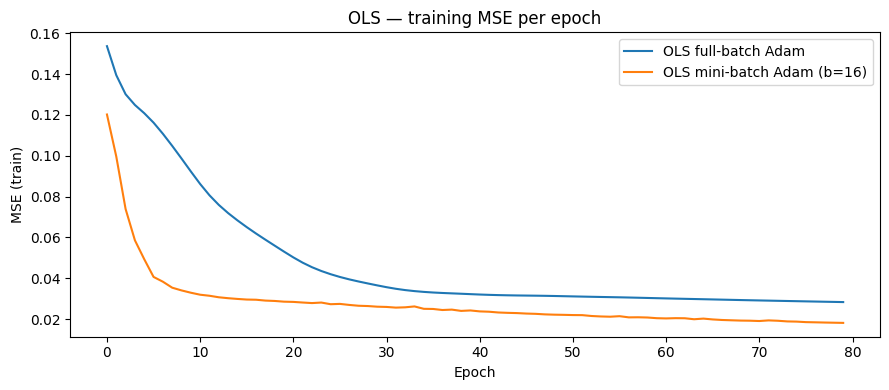

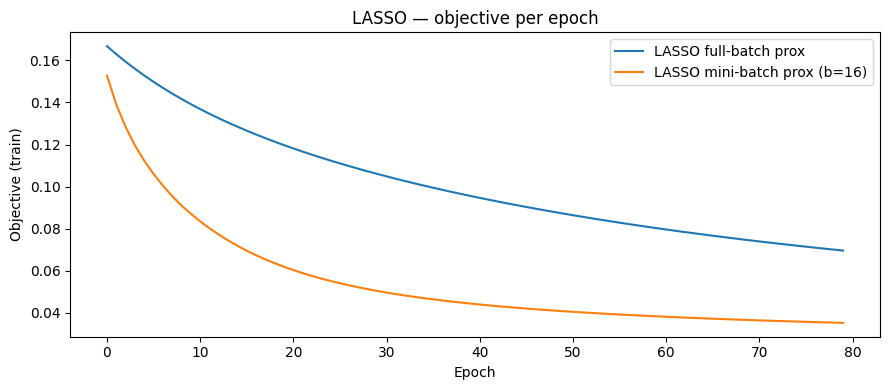

,Method,MSE (test),R^2 (test)
0,OLS full-batch Adam,0.030301,0.507386
1,OLS mini-batch Adam (b=16),0.020936,0.659644
2,Ridge mini-batch Momentum (b=16),0.031597,0.486325
3,LASSO full-batch prox,0.047369,0.229918
4,LASSO mini-batch prox (b=16),0.034584,0.437764


\begin{table}
\caption{Full-batch vs. mini-batch (SGD) for OLS, Ridge, and LASSO on the Runge task.}
\label{tab:sgd_results}
\begin{tabular}{lrr}
\toprule
Method & MSE (test) & R^2 (test) \\
\midrule
OLS full-batch Adam & 0.030301 & 0.507386 \\
OLS mini-batch Adam (b=16) & 0.020936 & 0.659644 \\
Ridge mini-batch Momentum (b=16) & 0.031597 & 0.486325 \\
LASSO full-batch prox & 0.047369 & 0.229918 \\
LASSO mini-batch prox (b=16) & 0.034584 & 0.437764 \\
\bottomrule
\end{tabular}
\end{table}



In [41]:
#Learning curves
plt.figure(figsize=(9,4))
plt.plot(h_fb, label="OLS full-batch Adam")
plt.plot(h_mb, label="OLS mini-batch Adam (b=16)")
plt.title("OLS — training MSE per epoch")
plt.xlabel("Epoch"); plt.ylabel("MSE (train)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(h_l_fb, label="LASSO full-batch prox")
plt.plot(h_l_mb, label="LASSO mini-batch prox (b=16)")
plt.title("LASSO — objective per epoch")
plt.xlabel("Epoch"); plt.ylabel("Objective (train)")
plt.legend(); plt.tight_layout(); plt.show()

#Results table
df_f = pd.DataFrame(results, columns=["Method", "MSE (test)", "R^2 (test)"]).round(6)
try:
    display(df_f)
except NameError:
    print(df_f)

#export to LaTeX for the report
print(df_f.to_latex(index=False,
    caption="Full-batch vs. mini-batch (SGD) for OLS, Ridge, and LASSO on the Runge task.",
    label="tab:sgd_results"))

# Part G


Best-by-CV rows:


,Model,Degree,Lambda,CV_MSE_mean,CV_MSE_std
0,OLS,14,0.0,0.007979,0.011473
1,Ridge,12,0.000007,0.004555,0.001199
2,LASSO,14,0.000007,0.004492,0.001731



Best-by-CV models evaluated on test:


,Model,Degree p,Lambda,MSE (test),R^2 (test)
0,LASSO,14,0.000007,0.002101,0.966954
1,OLS,14,0.000000,0.002273,0.964236
2,Ridge,12,0.000007,0.002103,0.966918



Concise summary (LASSO)
Best by CV → degree p=14, alpha=7.50e-06, CV_MSE=0.004492
Test MSE: 0.002101 | R^2: 0.966954


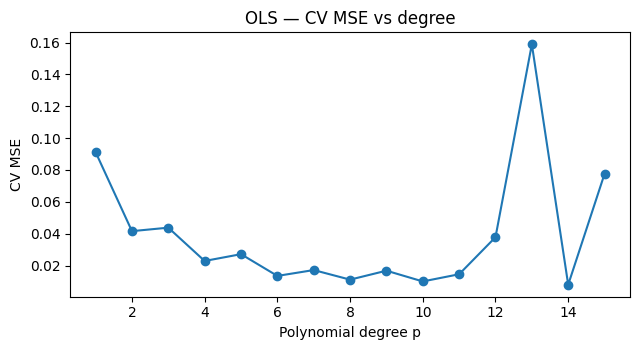

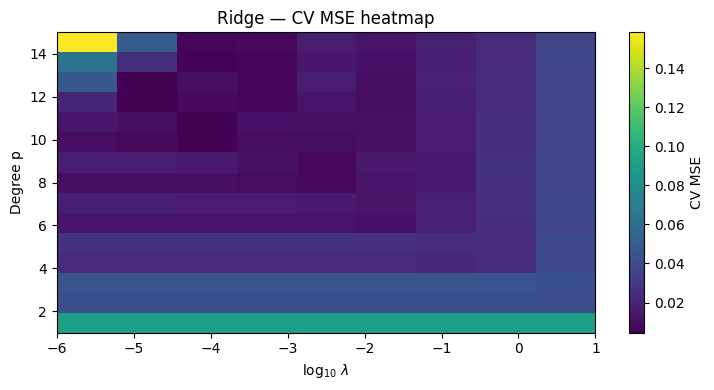

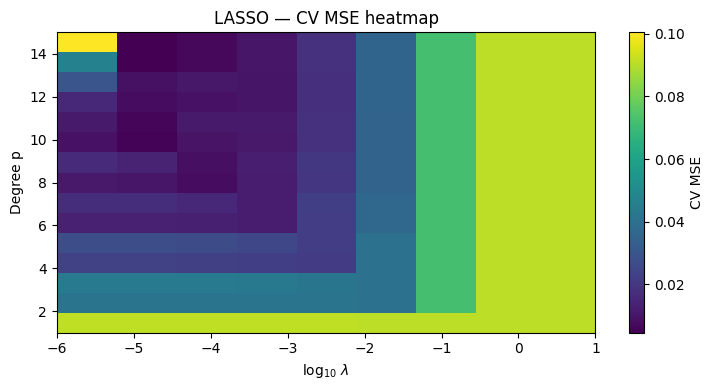

C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-01, tolerance: 6.516e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e-01, tolerance: 6.937e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca


Bootstrap bias–variance (on test):


C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e-01, tolerance: 7.814e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e-01, tolerance: 7.187e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

,Model,Bias^2,Variance,Noise (approx),Bias^2+Var
0,OLS,0.002177,0.003016,0.001509,0.005194
1,Ridge,0.002256,0.005325,0.001509,0.007581
2,LASSO,0.002817,0.002282,0.001509,0.005100


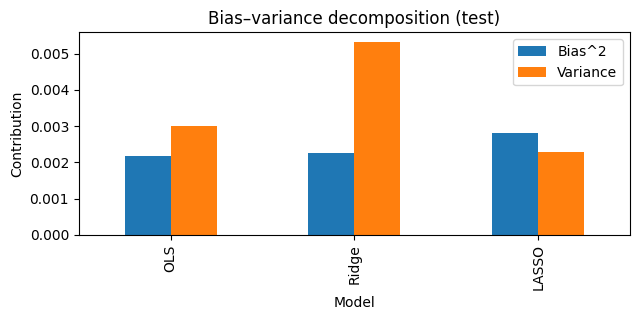

In [42]:
#Data (Reuse the settings)
rng = np.random.default_rng(42)
n, degree_max = 100, 15
x = np.linspace(-1, 1, n)
def runge(x, noise=0.05): return 1/(1+25*x**2) + rng.normal(0, noise, size=len(x))
y = runge(x, noise=0.05)

# Split once (fixed seed as earlier)
X = x.reshape(-1,1)  # polynomial features via PolynomialFeatures inside pipeline (implicit)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=73)

#Utility: poly pipelines
def poly_pipe(model, p):
    # Standardize only the polynomial terms. linear models have their own intercept.
    return make_pipeline(
        PolynomialFeatures(degree=p, include_bias=False),
        StandardScaler(with_mean=True, with_std=True),
        model
    )

def pipe_lasso(alpha, p, max_iter=20000, tol=1e-6):
    return poly_pipe(
        Lasso(alpha=alpha, fit_intercept=True,
              max_iter=max_iter, tol=tol,
              selection="cyclic", warm_start=True, random_state=0),
        p
    )

def pipe_lassolars(alpha, p):
    # Fallback solver for very small alphas (path method). We already scale in pipeline.
    return poly_pipe(LassoLars(alpha=alpha, fit_intercept=True, max_iter=500), p)

def fit_with_retries(pipeline, X, y, *, max_tries=3, max_iter_start=20000, factor=2.0, tol=1e-6):
    """Fit a Lasso pipeline: if ConvergenceWarning appears, bump max_iter and retry."""
    tries = 0; last_warn = None
    while tries < max_tries:
        tries += 1
        with warnings.catch_warnings(record=True) as wrec:
            warnings.simplefilter("always", ConvergenceWarning)
            pipeline.fit(X, y)
            conv_w = [w for w in wrec if issubclass(w.category, ConvergenceWarning)]
            if not conv_w:
                return pipeline, False
            last_warn = conv_w[-1]
        # increase max_iter if last step is Lasso
        est = pipeline[-1]
        if isinstance(est, Lasso):
            if tries == 1 and est.max_iter < max_iter_start:
                est.set_params(max_iter=max_iter_start, tol=tol)
            else:
                est.set_params(max_iter=int(est.max_iter * factor), tol=tol)
        else:
            break
    return pipeline, last_warn is not None

#Grid + K-fold CV
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=73)

deg_grid = list(range(1, degree_max+1))
lam_grid = np.logspace(-6, 1, 9)

cv_rows = []

# OLS
for p in deg_grid:
    mse_fold = []
    for tr_idx, va_idx in kf.split(X_tr):
        Xtr, Xva = X_tr[tr_idx], X_tr[va_idx]
        ytr, yva = y_tr[tr_idx], y_tr[va_idx]
        model = poly_pipe(LinearRegression(), p)
        model.fit(Xtr, ytr)
        yhat = model.predict(Xva)
        mse_fold.append(mean_squared_error(yva, yhat))
    cv_rows.append(("OLS", p, 0.0, np.mean(mse_fold), np.std(mse_fold)))

# Ridge
for p in deg_grid:
    for lam in lam_grid:
        mse_fold = []
        for tr_idx, va_idx in kf.split(X_tr):
            Xtr, Xva = X_tr[tr_idx], X_tr[va_idx]
            ytr, yva = y_tr[tr_idx], y_tr[va_idx]
            model = poly_pipe(Ridge(alpha=lam, fit_intercept=True, random_state=0), p)
            model.fit(Xtr, ytr)
            yhat = model.predict(Xva)
            mse_fold.append(mean_squared_error(yva, yhat))
        cv_rows.append(("Ridge", p, lam, np.mean(mse_fold), np.std(mse_fold)))

#LASSO - CV step (no warnings; auto-retry: optional LARS fallback)
for p in deg_grid:
    for lam in lam_grid:
        mse_fold = []
        warned_any = False
        for tr_idx, va_idx in kf.split(X_tr):
            Xtr, Xva = X_tr[tr_idx], X_tr[va_idx]
            ytr, yva = y_tr[tr_idx], y_tr[va_idx]
            # try Lasso; increase the max_iter if warning
            pipe = pipe_lasso(lam, p, max_iter=20000, tol=1e-5)
            pipe, warned = fit_with_retries(pipe, Xtr, ytr,
                                            max_tries=3, max_iter_start=20000,
                                            factor=2.0, tol=1e-6)
            warned_any |= warned
            # optional fallback for small alphas
            if warned and lam <= 1e-5:
                pipe = pipe_lassolars(lam, p)
                pipe.fit(Xtr, ytr)
            yhat = pipe.predict(Xva)
            mse_fold.append(mean_squared_error(yva, yhat))
        cv_rows.append(("LASSO", p, lam, np.mean(mse_fold), np.std(mse_fold)))

cv_df = pd.DataFrame(cv_rows, columns=["Model","Degree","Lambda","CV_MSE_mean","CV_MSE_std"])

#Pick best by CV_MSE_mean
best_ols   = cv_df.query("Model=='OLS'").sort_values("CV_MSE_mean").iloc[0]
best_ridge = cv_df.query("Model=='Ridge'").sort_values("CV_MSE_mean").iloc[0]
best_lasso = cv_df.query("Model=='LASSO'").sort_values("CV_MSE_mean").iloc[0]

best_rows = pd.concat([best_ols, best_ridge, best_lasso], axis=1).T.reset_index(drop=True)
print("\nBest-by-CV rows:")
try: display(best_rows)
except NameError: print(best_rows)

#Fit best models on full train: evaluate on test
def fit_eval(model_name, p, lam):
    if model_name=="OLS":
        model = poly_pipe(LinearRegression(), p)
    elif model_name=="Ridge":
        model = poly_pipe(Ridge(alpha=float(lam), fit_intercept=True, random_state=0), p)
    else:
        alpha = float(lam)
        model = pipe_lasso(alpha, p, max_iter=20000, tol=5e-7)
        model, warned = fit_with_retries(model, X_tr, y_tr,
                                         max_tries=3, max_iter_start=20000, factor=2.0, tol=5e-7)
        if warned and alpha <= 1e-5:
            model = pipe_lassolars(alpha, p)
            model.fit(X_tr, y_tr)
    model.fit(X_tr, y_tr)
    yhat = model.predict(X_te)
    return model, mean_squared_error(y_te, yhat), r2_score(y_te, yhat), yhat

best_models = {}
for row in best_rows.itertuples(index=False):
    mdl, mse_te, r2_te, yhat_te = fit_eval(row.Model, int(row.Degree), row.Lambda)
    best_models[row.Model] = dict(model=mdl, degree=int(row.Degree), lam=row.Lambda,
                                  mse=mse_te, r2=r2_te, yhat=yhat_te)

results_tbl = pd.DataFrame({
    "Model": list(best_models.keys()),
    "Degree p": [best_models[m]["degree"] for m in best_models],
    "Lambda":   [best_models[m]["lam"]    for m in best_models],
    "MSE (test)": [best_models[m]["mse"] for m in best_models],
    "R^2 (test)": [best_models[m]["r2"] for m in best_models],
}).sort_values("Model").reset_index(drop=True).round(6)

print("\nBest-by-CV models evaluated on test:")
try: display(results_tbl)
except NameError: print(results_tbl)

#Printing the concise summary lines
print("\nConcise summary (LASSO)")
print(f"Best by CV \u2192 degree p={int(best_lasso['Degree'])}, alpha={float(best_lasso['Lambda']):.2e}, CV_MSE={float(best_lasso['CV_MSE_mean']):.6f}")
print(f"Test MSE: {best_models['LASSO']['mse']:.6f} | R^2: {best_models['LASSO']['r2']:.6f}")

#Plots: CV curves and heatmaps
# OLS: CV MSE vs degree
ols_curve = cv_df.query("Model=='OLS'").sort_values("Degree")
plt.figure(figsize=(6.5,3.6))
plt.plot(ols_curve["Degree"], ols_curve["CV_MSE_mean"], marker="o")
plt.xlabel("Polynomial degree p"); plt.ylabel("CV MSE")
plt.title("OLS — CV MSE vs degree")
plt.tight_layout(); plt.show()

# Ridge/LASSO: heatmaps over (p, lambda)
def heatmap(model_name, title):
    sub = cv_df.query("Model==@model_name")
    pivot = sub.pivot(index="Degree", columns="Lambda", values="CV_MSE_mean")
    plt.figure(figsize=(7.5,4.0))
    im = plt.imshow(pivot.values, aspect="auto", origin="lower",
                    extent=[np.log10(pivot.columns.min()), np.log10(pivot.columns.max()),
                            pivot.index.min(), pivot.index.max()])
    plt.colorbar(im, label="CV MSE")
    plt.xlabel(r"$\log_{10}\,\lambda$"); plt.ylabel("Degree p")
    plt.title(title)
    plt.tight_layout(); plt.show()

heatmap("Ridge", "Ridge — CV MSE heatmap")
heatmap("LASSO", "LASSO — CV MSE heatmap")

#Bootstrap bias–variance on the test set
def bootstrap_bias_variance(model_ctor, p, lam, B=300, seed=7):
    rng = np.random.default_rng(seed)
    preds = []
    for b in range(B):
        idx = rng.integers(0, len(X_tr), size=len(X_tr))
        Xb, yb = X_tr[idx], y_tr[idx]
        model = model_ctor(p, lam)
        model.fit(Xb, yb)
        preds.append(model.predict(X_te))
    P = np.vstack(preds)
    mu = P.mean(axis=0)
    bias2 = np.mean((mu - y_te)**2)
    var   = np.mean(P.var(axis=0, ddof=1))
    noise = np.mean((y_te - runge(X_te.ravel(), noise=0.0))**2)
    mse_est = bias2 + var
    return bias2, var, noise, mse_est

def ctor(model_name):
    if model_name=="OLS":
        return lambda p, lam: poly_pipe(LinearRegression(), p)
    if model_name=="Ridge":
        return lambda p, lam: poly_pipe(Ridge(alpha=float(lam), fit_intercept=True, random_state=0), p)
    return lambda p, lam: pipe_lasso(alpha=float(lam), p=p, max_iter=20000, tol=1e-6)

bv_rows = []
for mname, info in best_models.items():
    b2, var, noise, mse_est = bootstrap_bias_variance(ctor(mname), info["degree"], info["lam"], B=300)
    bv_rows.append([mname, b2, var, noise, mse_est])

bv_df = pd.DataFrame(bv_rows, columns=["Model","Bias^2","Variance","Noise (approx)","Bias^2+Var"]).round(6)
print("\nBootstrap bias–variance (on test):")
try: display(bv_df)
except NameError: print(bv_df)

# Simple bar plot
ax = bv_df.set_index("Model")[["Bias^2","Variance"]].plot(kind="bar", figsize=(6.5,3.3))
ax.set_ylabel("Contribution"); ax.set_title("Bias–variance decomposition (test)")
plt.tight_layout(); plt.show()



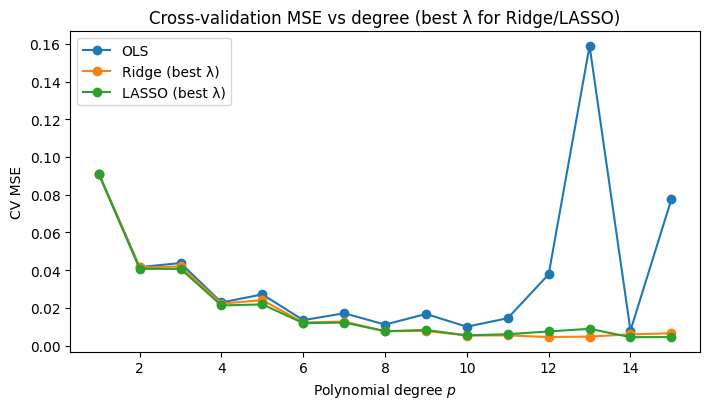

In [43]:
#Line chart: CV MSE vs degree (best λ for Ridge/LASSO)
ols_curve   = (cv_df[cv_df["Model"]=="OLS"]
               .sort_values("Degree")[["Degree","CV_MSE_mean"]]
               .rename(columns={"CV_MSE_mean":"OLS"}))

ridge_curve = (cv_df[cv_df["Model"]=="Ridge"]
               .groupby("Degree", as_index=False)["CV_MSE_mean"].min()
               .rename(columns={"CV_MSE_mean":"Ridge (best λ)"}))

lasso_curve = (cv_df[cv_df["Model"]=="LASSO"]
               .groupby("Degree", as_index=False)["CV_MSE_mean"].min()
               .rename(columns={"CV_MSE_mean":"LASSO (best λ)"}))

df_cv_lines = (ols_curve
               .merge(ridge_curve, on="Degree")
               .merge(lasso_curve, on="Degree"))

plt.figure(figsize=(7.2,4.2))
plt.plot(df_cv_lines["Degree"], df_cv_lines["OLS"], marker="o", label="OLS")
plt.plot(df_cv_lines["Degree"], df_cv_lines["Ridge (best λ)"], marker="o", label="Ridge (best λ)")
plt.plot(df_cv_lines["Degree"], df_cv_lines["LASSO (best λ)"], marker="o", label="LASSO (best λ)")
plt.xlabel("Polynomial degree $p$")
plt.ylabel("CV MSE")
plt.title("Cross-validation MSE vs degree (best λ for Ridge/LASSO)")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/cv_mse_vs_degree_comparison.png", dpi=200)
plt.show()


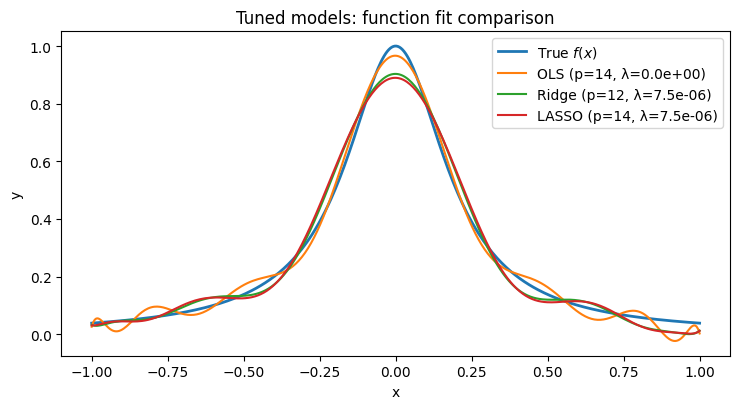

In [44]:
#Line chart: true function vs tuned models on a dense grid
xx = np.linspace(-1, 1, 400).reshape(-1,1)

def predict_with_pipeline(pipe, xgrid):
    return pipe.predict(xgrid)

#Making sure best_models has the fitted pipeline
y_true = 1/(1 + 25*xx.ravel()**2)

plt.figure(figsize=(7.5,4.2))
plt.plot(xx, y_true, label="True $f(x)$", linewidth=2)

for name in ["OLS","Ridge","LASSO"]:
    yhat = predict_with_pipeline(best_models[name]["model"], xx)
    plt.plot(xx, yhat, label=f"{name} (p={best_models[name]['degree']}, λ={best_models[name]['lam']:.1e})")

plt.xlabel("x"); plt.ylabel("y")
plt.title("Tuned models: function fit comparison")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/tuned_models_function_fit.png", dpi=200)
plt.show()


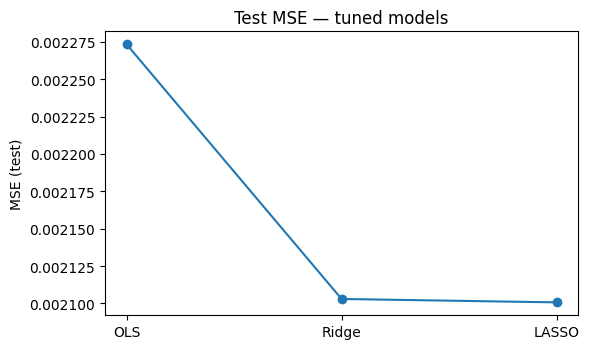

In [45]:
plt.figure(figsize=(6,3.6))
plt.plot(["OLS","Ridge","LASSO"],
         [best_models[m]["mse"] for m in ["OLS","Ridge","LASSO"]],
         marker="o")
plt.ylabel("MSE (test)")
plt.title("Test MSE — tuned models")
plt.tight_layout()
plt.savefig("Figures/test_mse_tuned_models.png", dpi=200)
plt.show()


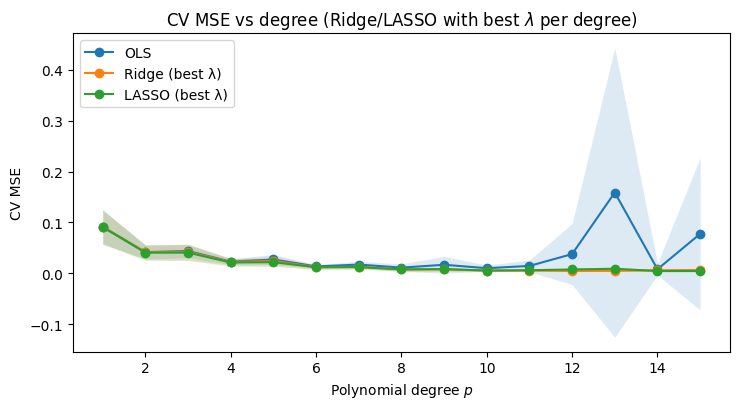

In [46]:
#CV MSE vs degree for OLS, Ridge (best λ), LASSO (best λ)
#expects: cv_df with columns ["Model","Degree","Lambda","CV_MSE_mean","CV_MSE_std"]
ols_deg = (cv_df[cv_df["Model"]=="OLS"]
           .sort_values("Degree")[["Degree","CV_MSE_mean","CV_MSE_std"]]
           .rename(columns={"CV_MSE_mean":"OLS_mean","CV_MSE_std":"OLS_std"}))

ridge_best = (cv_df[cv_df["Model"]=="Ridge"]
              .sort_values(["Degree","CV_MSE_mean"])
              .groupby("Degree", as_index=False)
              .first()[["Degree","CV_MSE_mean","CV_MSE_std"]]
              .rename(columns={"CV_MSE_mean":"Ridge_mean","CV_MSE_std":"Ridge_std"}))

lasso_best = (cv_df[cv_df["Model"]=="LASSO"]
              .sort_values(["Degree","CV_MSE_mean"])
              .groupby("Degree", as_index=False)
              .first()[["Degree","CV_MSE_mean","CV_MSE_std"]]
              .rename(columns={"CV_MSE_mean":"LASSO_mean","CV_MSE_std":"LASSO_std"}))

df_plot = ols_deg.merge(ridge_best, on="Degree").merge(lasso_best, on="Degree")

plt.figure(figsize=(7.5,4.2))
plt.plot(df_plot["Degree"], df_plot["OLS_mean"],   marker="o", label="OLS")
plt.plot(df_plot["Degree"], df_plot["Ridge_mean"], marker="o", label="Ridge (best λ)")
plt.plot(df_plot["Degree"], df_plot["LASSO_mean"], marker="o", label="LASSO (best λ)")

# Optional: 1-std "error bands" from CV
for mean_col, std_col, color in [
    ("OLS_mean","OLS_std","C0"),
    ("Ridge_mean","Ridge_std","C1"),
    ("LASSO_mean","LASSO_std","C2"),
]:
    mu = df_plot[mean_col].values
    sd = df_plot[std_col].values
    deg = df_plot["Degree"].values
    plt.fill_between(deg, mu - sd, mu + sd, alpha=0.15, color=color, linewidth=0)

plt.xlabel("Polynomial degree $p$")
plt.ylabel("CV MSE")
plt.title("CV MSE vs degree (Ridge/LASSO with best $\\lambda$ per degree)")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/cv_mse_vs_degree_all_models.png", dpi=200)
plt.show()


# Part H

C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-01, tolerance: 7.110e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e-02, tolerance: 7.079e-06
  model = cd_fast.enet_coordinate_descent(
C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca


Part H — model selection with scikit-learn (GridSearchCV):


C:\Users\NecoD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e-01, tolerance: 6.194e-06
  model = cd_fast.enet_coordinate_descent(


,Model,Best degree p,Best λ (alpha),CV MSE (mean),Test MSE,Test R^2,Nested CV MSE (mean),Nested CV MSE (std)
0,OLS,14,0.000000,0.007979,0.002273,0.964236,0.003428,0.002911
1,Ridge,12,0.000007,0.004555,0.002103,0.966918,0.004595,0.002307
2,LASSO,11,0.000001,0.005466,0.002040,0.967915,0.004565,0.001927


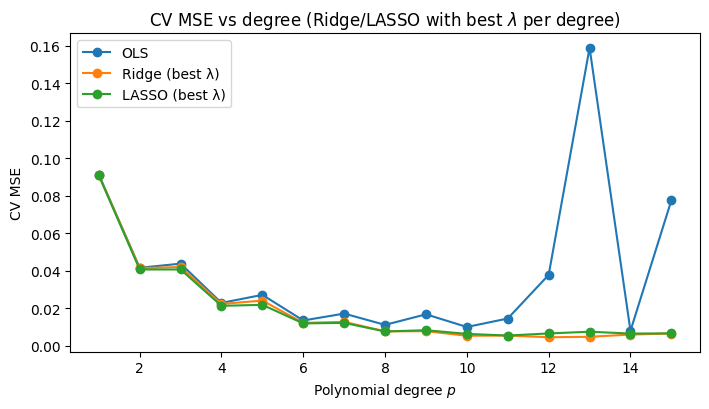

In [48]:
#Part H — Cross-validation with scikit-learn

#Data (same as before)
rng = np.random.default_rng(42)
n = 100
x = np.linspace(-1, 1, n)
def runge(x, noise=0.05):
    return 1/(1+25*x**2) + rng.normal(0, noise, size=len(x))
y = runge(x, noise=0.05)

# One fixed train/test split for final evaluation
X = x.reshape(-1, 1)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=73)

# Pipelines
def poly_std_then(model):
    return make_pipeline(
        PolynomialFeatures(include_bias=False),
        StandardScaler(with_mean=True, with_std=True),
        model
    )

pipe_ols   = poly_std_then(LinearRegression())
pipe_ridge = poly_std_then(Ridge(random_state=0))
pipe_lasso = poly_std_then(Lasso(random_state=0, max_iter=200_000, tol=1e-6, selection="cyclic"))

#Hyperparameter grids
deg_grid   = list(range(1, 16))          # polynomial degree p
lam_grid   = np.logspace(-6, 1, 9)      # 1e-6 ... 10 (λ = alpha in sklearn)

param_ols   = {"polynomialfeatures__degree": deg_grid}
param_ridge = {"polynomialfeatures__degree": deg_grid,
               "ridge__alpha": lam_grid}
param_lasso = {"polynomialfeatures__degree": deg_grid,
               "lasso__alpha": lam_grid}

#Grid-search CV on the training set
cv = KFold(n_splits=5, shuffle=True, random_state=73)
scorer = "neg_mean_squared_error"  # we’ll report MSE (lower is better)

def run_grid(pipe, grid, name):
    gs = GridSearchCV(pipe, grid, scoring=scorer, cv=cv, n_jobs=-1, refit=True, return_train_score=False)
    gs.fit(X_tr, y_tr)
    best_deg = gs.best_params_["polynomialfeatures__degree"]
    if name == "OLS":
        best_alpha = 0.0
    else:
        key = f"{name.lower()}__alpha"
        best_alpha = gs.best_params_[key]
    # Evaluate on held-out test set
    yhat = gs.predict(X_te)
    mse_te = mean_squared_error(y_te, yhat)
    r2_te  = r2_score(y_te, yhat)
    return gs, best_deg, best_alpha, -gs.best_score_, mse_te, r2_te

gs_ols,   p_ols,   a_ols,   cv_ols,   mse_ols,   r2_ols   = run_grid(pipe_ols,   param_ols,   "OLS")
gs_ridge, p_ridge, a_ridge, cv_ridge, mse_ridge, r2_ridge = run_grid(pipe_ridge, param_ridge, "Ridge")
gs_lasso, p_lasso, a_lasso, cv_lasso, mse_lasso, r2_lasso = run_grid(pipe_lasso, param_lasso, "Lasso")

#Optional: nested CV for generalisation estimate
def nested_cv_estimate(pipe, grid, outer_splits=5):
    outer = KFold(n_splits=outer_splits, shuffle=True, random_state=123)
    scores = []
    for tr_idx, te_idx in outer.split(X):
        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]
        inner = KFold(n_splits=5, shuffle=True, random_state=73)
        gs = GridSearchCV(clone(pipe), grid, scoring=scorer, cv=inner, n_jobs=-1, refit=True)
        gs.fit(Xtr, ytr)
        yhat = gs.predict(Xte)
        scores.append(mean_squared_error(yte, yhat))
    scores = np.array(scores)
    return float(scores.mean()), float(scores.std())

nest_ols_mean,   nest_ols_std   = nested_cv_estimate(pipe_ols,   param_ols)
nest_ridge_mean, nest_ridge_std = nested_cv_estimate(pipe_ridge, param_ridge)
nest_lasso_mean, nest_lasso_std = nested_cv_estimate(pipe_lasso, param_lasso)

#Results table
results = pd.DataFrame({
    "Model": ["OLS","Ridge","LASSO"],
    "Best degree p": [p_ols, p_ridge, p_lasso],
    "Best λ (alpha)": [a_ols, a_ridge, a_lasso],
    "CV MSE (mean)": [cv_ols, cv_ridge, cv_lasso],
    "Test MSE": [mse_ols, mse_ridge, mse_lasso],
    "Test R^2": [r2_ols, r2_ridge, r2_lasso],
    "Nested CV MSE (mean)": [nest_ols_mean, nest_ridge_mean, nest_lasso_mean],
    "Nested CV MSE (std)": [nest_ols_std, nest_ridge_std, nest_lasso_std],
}).round(6)

print("\nPart H — model selection with scikit-learn (GridSearchCV):")
try: display(results)
except NameError: print(results)


#CV MSE vs degree per model
#Uses best-λ-per-degree for Ridge/LASSO
cv_df = []
# grab CV results from the fitted grid searches
def collect_curve(gsearch, model_name):
    df = pd.DataFrame(gsearch.cv_results_)
    df["Degree"] = df["param_polynomialfeatures__degree"].astype(int)
    df["Model"] = model_name
    df["CV_MSE"] = -df["mean_test_score"]
    return df[["Model","Degree","CV_MSE"]]

cv_ols_df   = collect_curve(gs_ols,   "OLS").groupby("Degree", as_index=False)["CV_MSE"].min()
cv_ridge_df = collect_curve(gs_ridge, "Ridge").groupby("Degree", as_index=False)["CV_MSE"].min()
cv_lasso_df = collect_curve(gs_lasso, "LASSO").groupby("Degree", as_index=False)["CV_MSE"].min()

plt.figure(figsize=(7.2,4.2))
plt.plot(cv_ols_df["Degree"], cv_ols_df["CV_MSE"],   marker="o", label="OLS")
plt.plot(cv_ridge_df["Degree"], cv_ridge_df["CV_MSE"], marker="o", label="Ridge (best λ)")
plt.plot(cv_lasso_df["Degree"], cv_lasso_df["CV_MSE"], marker="o", label="LASSO (best λ)")
plt.xlabel("Polynomial degree $p$"); plt.ylabel("CV MSE")
plt.title("CV MSE vs degree (Ridge/LASSO with best $\\lambda$ per degree)")
plt.legend(); plt.tight_layout()
plt.savefig("Figures/cv_mse_vs_degree.png", dpi=200)
plt.show()


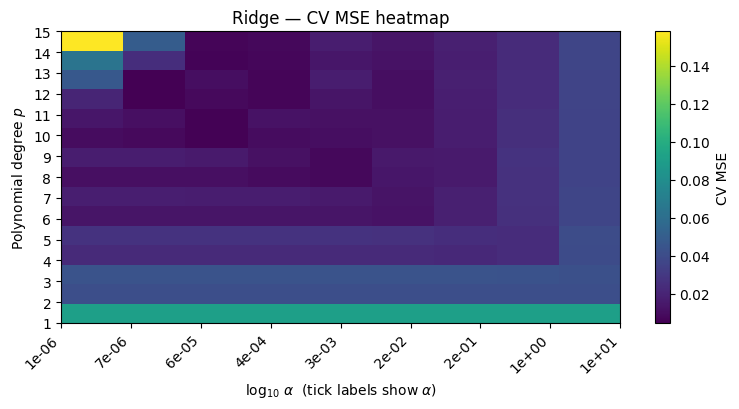

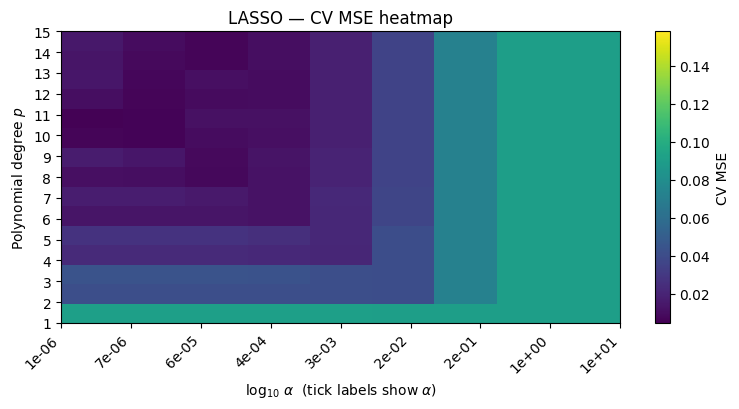

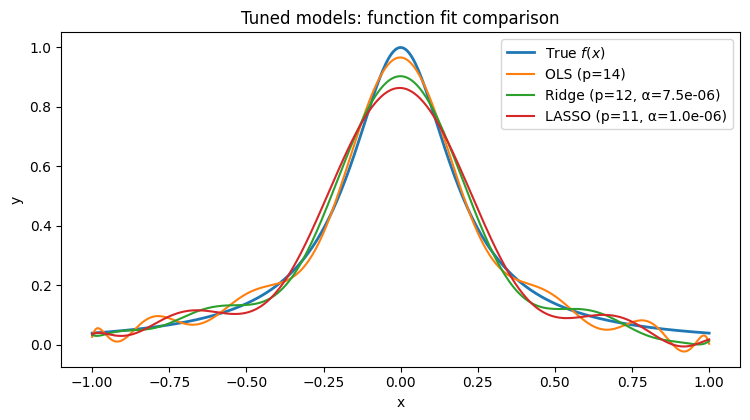

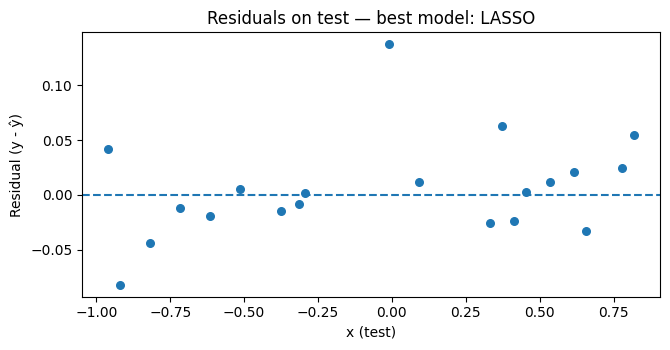

In [49]:
def cv_heatmap_from_gs(gs, model_name, figpath, vmin=None, vmax=None):
    """
    Creating a CV MSE heatmap over (degree p, log10 alpha) for a fitted GridSearchCV 'gs'.
    """
    df = pd.DataFrame(gs.cv_results_)
    if model_name.lower() == "ridge":
        alpha_col = "param_ridge__alpha"
    elif model_name.lower() == "lasso":
        alpha_col = "param_lasso__alpha"
    else:
        raise ValueError("Heatmap only makes sense for Ridge or LASSO.")

    #extract numeric params
    df["Degree"] = df["param_polynomialfeatures__degree"].astype(int)
    df["Alpha"]  = df[alpha_col].astype(float)
    df["log10_alpha"] = np.log10(df["Alpha"].values)
    df["CV_MSE"] = -df["mean_test_score"].values

    #pivot Degree (rows) x log10_alpha (cols)
    piv = df.pivot_table(index="Degree", columns="log10_alpha", values="CV_MSE", aggfunc="mean")
    cols_sorted = np.sort(piv.columns.values)
    piv = piv[cols_sorted].sort_index()

    # ticks for lambda
    xticks = cols_sorted
    xtick_labels = [fr"{10**x:.0e}" for x in xticks]   # show α scientific notation

    plt.figure(figsize=(7.8, 4.2))
    im = plt.imshow(piv.values, aspect="auto", origin="lower",
                    extent=[cols_sorted.min(), cols_sorted.max(),
                            piv.index.min(), piv.index.max()],
                    vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label="CV MSE")
    plt.xlabel(r"$\log_{10}\,\alpha$  (tick labels show $\alpha$)")
    plt.ylabel("Polynomial degree $p$")
    plt.title(f"{model_name} — CV MSE heatmap")

    # place ticks at the actual grid points
    plt.xticks(xticks, xtick_labels, rotation=45, ha="right")
    plt.yticks(sorted(piv.index.values))

    plt.tight_layout()
    plt.savefig(figpath, dpi=200)
    plt.show()
    return piv

#Heatmaps (Ridge & LASSO)
ridge_piv = cv_heatmap_from_gs(gs_ridge, "Ridge", "Figures/partH_ridge_cv_heatmap.png")
lasso_piv = cv_heatmap_from_gs(gs_lasso, "LASSO", "Figures/partH_lasso_cv_heatmap.png",
                               vmin=ridge_piv.values.min(), vmax=ridge_piv.values.max())

#Tuned function fits (true f(x) vs the three CV-selected models)
xx = np.linspace(-1, 1, 400).reshape(-1, 1)
y_true = 1/(1 + 25*xx.ravel()**2)

def predict_with_gs(gsearch, Xgrid):
    """Predicting using the refit best_estimator_ of a fitted GridSearchCV."""
    return gsearch.best_estimator_.predict(Xgrid).ravel()

plt.figure(figsize=(7.6, 4.3))
plt.plot(xx, y_true, label="True $f(x)$", linewidth=2)
plt.plot(xx, predict_with_gs(gs_ols,   xx), label=f"OLS (p={p_ols})")
plt.plot(xx, predict_with_gs(gs_ridge, xx), label=f"Ridge (p={p_ridge}, α={a_ridge:.1e})")
plt.plot(xx, predict_with_gs(gs_lasso, xx), label=f"LASSO (p={p_lasso}, α={a_lasso:.1e})")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Tuned models: function fit comparison")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/tuned_models_function_fit.png", dpi=200)
plt.show()

#Residual plot for the best test model
# pick the model with lowest test MSE
best_name = ["OLS","Ridge","LASSO"][np.argmin([mse_ols, mse_ridge, mse_lasso])]
best_gs = {"OLS": gs_ols, "Ridge": gs_ridge, "LASSO": gs_lasso}[best_name]
yhat_te_best = best_gs.best_estimator_.predict(X_te).ravel()
resid = y_te - yhat_te_best

plt.figure(figsize=(6.8, 3.6))
plt.scatter(X_te.ravel(), resid, s=30)
plt.axhline(0.0, linestyle="--")
plt.xlabel("x (test)")
plt.ylabel("Residual (y - ŷ)")
plt.title(f"Residuals on test — best model: {best_name}")
plt.tight_layout()
plt.savefig("Figures/partH_best_model_residuals.png", dpi=200)
plt.show()